In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

from scipy.stats import multivariate_normal

# Problem 1
## Experiment with Gaussian Descriminators

In [4]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix
    
    # N: training examples
    # d: features
    # k: classes
    
    N, d = X.shape
    unique_classes = np.unique(y) # grab each unique value
    k = unique_classes.size
    
    _means = []
    for uc in unique_classes:
        is_class = (y == uc).reshape(y.shape[0], ) # condition-matrix where y is the class
        from_class = X[is_class]                   # grab from X where y is the class
        class_means = np.mean(from_class, axis=0)  # get the means for each column (d columns)
        _means.append(class_means)

    means = np.array(_means).T # reshape means to be d x k (versus k x d)
    
    covmat = np.cov(X.T)
    
    return means,covmat

In [5]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    res = np.zeros(len(ytest))
    for i, x in enumerate(Xtest):
        y = ytest[i]
        values = []
        for mean in means.T:
            values.append(multivariate_normal.pdf(x, mean, covmat))

        res[i] = np.argmax(np.array(values)) + 1 # we add one to match index
        
    acc = sum(res - ytest.reshape(len(ytest), ) == 0)/len(res)
            
    return acc, np.array(res).reshape(ytest.shape)

In [6]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    N, d = X.shape
    unique_classes = np.unique(y) # grab each unique value
    k = unique_classes.size
    
    _means = []
    covmats = []
    for uc in unique_classes:
        is_class = (y == uc).reshape(y.shape[0], ) # condition-matrix where y is the class
        from_class = X[is_class]                   # grab from X where y is the class
        class_means = np.mean(from_class, axis=0)  # get the means for each column (d columns)
        _means.append(class_means)
        
        covmat = np.cov(from_class.T)
        covmats.append(covmat)

    means = np.array(_means).T # reshape means to be d x k (versus k x d)
    
    return means,covmats

In [7]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    res = np.zeros(len(ytest))
    for i, x in enumerate(Xtest):
        y = ytest[i]
        values = []
        for j in range(len(means.T)):
            mean = means.T[j]
            covmat = covmats[j]
            values.append(multivariate_normal.pdf(x, mean, covmat))

        res[i] = np.argmax(np.array(values)) + 1 # we add one to match index
        
    acc = sum(res - ytest.reshape(len(ytest), ) == 0)/len(res)
            
    return acc, np.array(res).reshape(ytest.shape)

LDA Accuracy = 0.97
QDA Accuracy = 0.96


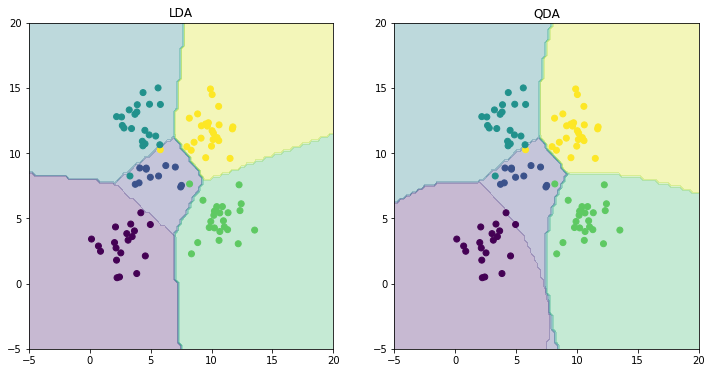

In [8]:
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

#LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))

# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.reshape(ytest.size, ))
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.reshape(ytest.size, ))
plt.title('QDA')

plt.show()

For this problem, we trained our implementation of **Linear Discriminant Analysis** (LDA) and **Quadratic Discriminant Analysis** (QDA) on the sample training data (**sample_train**).

We see that the accuracy of LDA is 97% (97/100 correctly classified) and QDA is 96% (96/100 correctly classified).  The plots show the example points (with each point being a different color based on classification and each boundary's area being a different color based on the same scheme).

Notice the difference in the shape of the boundaries.  For LDA, we see the shape is more linear, while for QDA the shape is more quadratic.  This is because our use of each class' covarience matrix allows for more degrees of freedom through more trained variables, making the QDA's boundaries fit more closely with the data (despite this actually leading to less accuracy in this example).

# Problem 2
## Experiment with Linear Regression

In [9]:
def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    N = float(Xtest.shape[0])
    return (1/N) * np.dot((ytest - np.dot(Xtest, w)).T, (ytest - np.dot(Xtest, w)))[0,0]

Functions Agree: True
(solid red line and green dotted line should match)


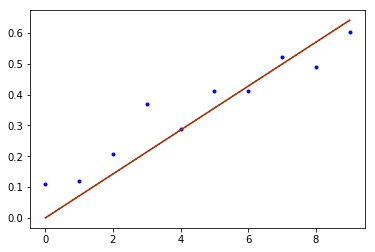

MSE (these should all be the same):

0.005466563777866237
0.005466563777866237
0.005466563777866237


In [10]:
# Testing our learnOLERegression versus Numpy's

# Generate Data
count = 10
x_test = np.arange(count).astype(float).reshape(count, 1)
y_test = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_test[i] = np.random.rand()/4 + x/20
    
plt.plot(x_test, y_test, 'b.')

# Use Numpy's function
z,resid,rank,sigma = np.linalg.lstsq(x_test, y_test, rcond=None)
y_lib = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_lib[i] = x*z
    
plt.plot(x_test, y_lib, 'r-')

# User our function
w = learnOLERegression(x_test,y_test)
y_our = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_our[i] = x*w
    
plt.plot(x_test, y_our, 'g:')

in_agreeance = np.allclose(y_our, y_lib)
print("Functions Agree:", in_agreeance)
if in_agreeance:
    print("(solid red line and green dotted line should match)")
plt.show()

print("MSE (these should all be the same):\n")
print(((y_lib - y_test)**2).mean()) # simple implimintation
print(((y_our - y_test)**2).mean())
print(testOLERegression(w,x_test,y_test))

In [11]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

MSE without intercept 106775.36155730896
MSE with intercept 3707.8401815996954


In [16]:
print("Gain in accuracy:", mle-mle_i)

Gain in accuracy: 103067.52137570927
Gain in accuracy: 27.79718551171271


For problem 2, we implement *ordinary least squares method* to estimate regression parameters by minimizing the squared loss.  We note the MSE is **106775.36155730896** when not using an intercept and **3707.8401815996954** when using an intercept (a gain in accuracy of about **103067**).

This increase in accuracy can be attributed to the fact that adding the intercept allows for the regression to fit the data more closely by adding another dimension of freedom for the resulting hyperplane to be translated over.

# Problem 3
## Experiment with Ridge Regression

In [19]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    return np.dot(np.linalg.inv(np.dot(X.T, X) + lambd*np.identity(X.shape[1])), np.dot(X.T, y))

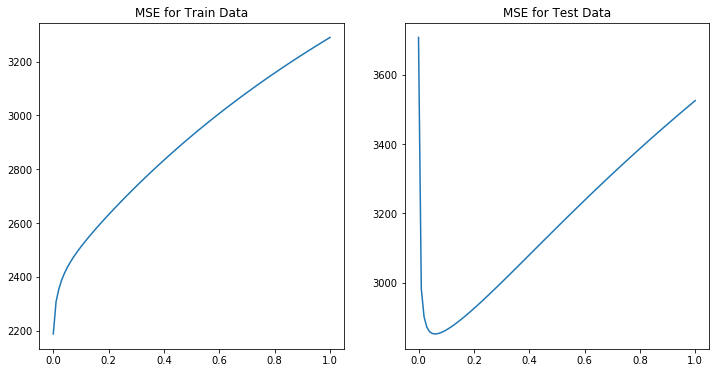

In [20]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

In [25]:
best_lambd = lambdas[np.argmin(mses3)]
w_l = learnRidgeRegression(X_i,y,best_lambd)
mle_ridge = testOLERegression(w_l,Xtest_i,ytest)
print('MSE with intercept '+str(mle_ridge))
print('Magnitudes of Ridge Weights:', sum(abs(w_l))[0])
print('Magnitudes without Ridge:', sum(abs(w_i))[0])

MSE with intercept 2851.3302134438477
Magnitudes of Ridge Weights: 5240.0949268758395
Magnitudes without Ridge: 286570.97996703925


For this problem, we implement *Ridge Regression*, similar to linear regression like before, but with *L2 regularization*.  This regularization pentalizes complexity by adding a term to the error equivalnet to the squared sum of the weights multiplied by some constant $\lambda$.

In our implementation, we vary $\lambda$ through 100 equally spaced values between 0 and 1 and use this value to train and test the regression.  In doing so, we found that the $\lambda$ that produces the highest accuracy in the test data is *0.06*.  This value provides optimal accuracy in that it limits the complexity of the regression (i.e., keeping the weights lower than without it), so as to prevent overfitting.

When comparing the magnitudes of the weights for regression using and not using regularization, we see a drastic change.  When not using regularization (i.e., the previous problem), we have a magnitude of about **286,570**.  When using regularization, the magnitude it **5,240**.

# Problem 4
## Using Gradient Descent for Ridge Regression Learning

In [38]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda
    
    N = float(Xtest.shape[0])
    resid = np.squeeze((np.dot(X, np.expand_dims(w, 1)) - y))
    error = (1/N)*(np.dot(resid.T, resid) + lambd*np.dot(w.T, w))
    error_grad = np.dot(X.T, resid)  + lambd*w
    error_grad /= N
    
    return error, error_grad

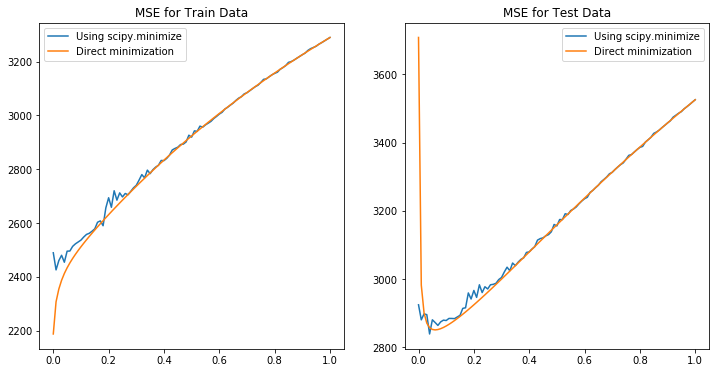

In [39]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

For this problem, we re-implement Ridge Regression, but this time by utilizing *Gradient Descent*.  The reason we'd use this method over directly computing the regression is that the closed-form solution of ordinary least squares regression involves taking an inverse of a marix, which may not be suitable in a numerical setting.  Gradient Descent helps us avoid this issue (at the cost of training time and volatility in training).

We see in the plots that Gradient Descent is more erratic in terms of error for every $\lambda$ we use in learning.  This is due to the nature of Gradient Descent and the uncertainty (and sometime inability) of the algorithm to properly find a global minimia.

Despite this, Gradient Descent performs well relative to the closed form solution, with higher values of $\lambda$ producing more closely aligned errors.

# Problem 5
## Non-linear Regression

In [40]:
def mapNonLinear(x,p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    N = x.shape[0]
    Xp = np.zeros((N, p+1))
    for deg in range(p+1):
        Xp[:,deg] = x ** deg
    return Xp

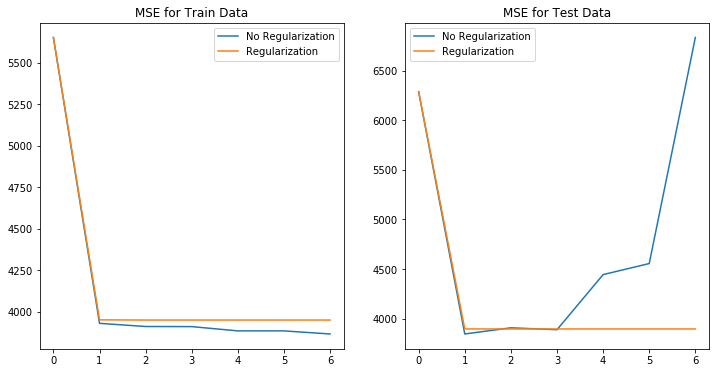

In [48]:
pmax = 7
lambda_opt = 0.06 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()

For problem 5, we investigate the impact of using higher order polynomials for the input features.  This converts a single attribute **x** into a vector of *p* attributes, *1, x, $x^2$, ..., $x^p$*.  For this problem, we only use the third variable as the input variable.

We plot the MSE for both no regularization ($\lambda = 0$) and regularization using our optimal value from problem 3 ($\lambda = 0.06$) as we vary *p* from 0 to 6.

We find that the optimal range of values for *p* for the test data is from 1 to 3, with *p=1* providing the best accuracy.  We note that, as *p* increases past 3, the training error decreases but the testing error increases dramitcally.  This can be attributed to overfitting, as the higher degreed polynomials can better fit the training data.

# Problem 6
## Interpreting Results

Based on the previous results, it would seem using Ridge Regression is the best approach in terms of training and testing error for anyone using regression for predicting diabetes levels using the input features.  In application, it would probably be best to use Gradient Descent in order to avoid computational issues with the closed-form version.  Using non-linear regression might provide higher accuracy (at least in terms of training error), but can lead to overfitting quickly, even with regularization.

Anyone using regression will want to use the MSE of their testing set to choose the best setting.  This will prevent them from selecting an approach that is prone to overfitting or isn't accurate.